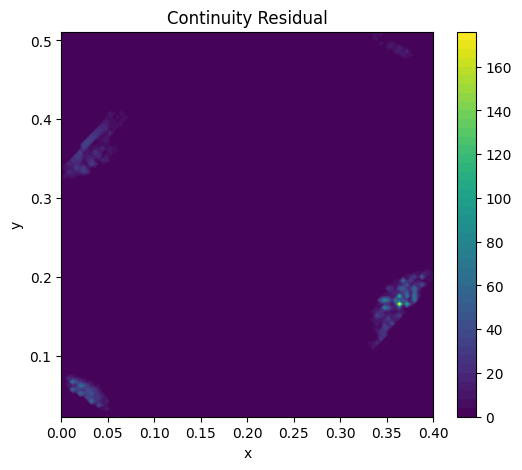

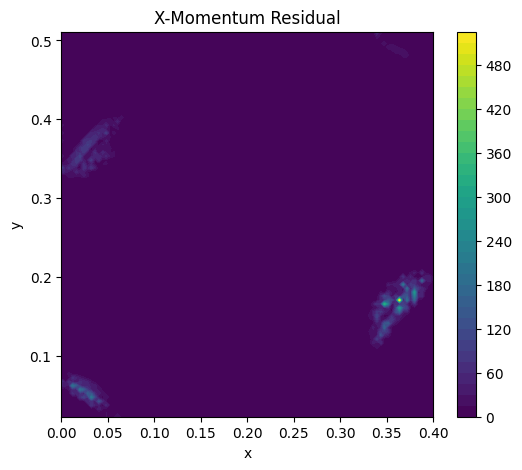

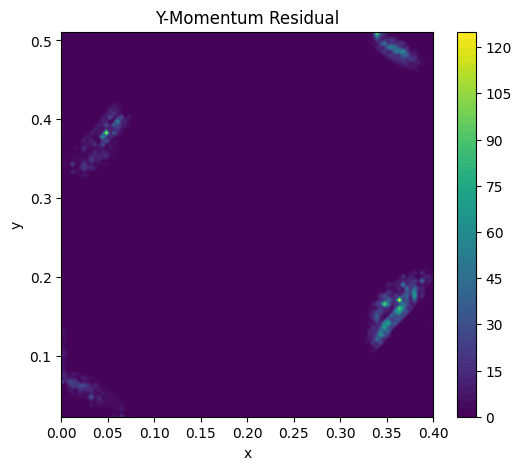

Average Continuity Residual: 0.9563947842609014
Average X-Momentum Residual: 2.10881173778912
Average Y-Momentum Residual: 0.732755075834728


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load CSV
mode = "label_free"
df = pd.read_csv(f'results/csv/test_{mode}_0.35_3_1.csv')  # replace with your file path

x_data, y_data = df['x'], df['y']
u_data, v_data = df['u'], df['v']
p_data = df['p']

# Define grid
nx, ny = 100, 100  # grid resolution
xi = np.linspace(x_data.min(), x_data.max(), nx)
yi = np.linspace(y_data.min(), y_data.max(), ny)
X, Y = np.meshgrid(xi, yi)

# Interpolate scattered data to grid
U = griddata((x_data, y_data), u_data, (X, Y), method='cubic')
V = griddata((x_data, y_data), v_data, (X, Y), method='cubic')
P = griddata((x_data, y_data), p_data, (X, Y), method='cubic')

# Fill NaN with nearest interpolation (optional)
U[np.isnan(U)] = griddata((x_data, y_data), u_data, (X, Y), method='nearest')[np.isnan(U)]
V[np.isnan(V)] = griddata((x_data, y_data), v_data, (X, Y), method='nearest')[np.isnan(V)]
P[np.isnan(P)] = griddata((x_data, y_data), p_data, (X, Y), method='nearest')[np.isnan(P)]

# Define viscosity
nu = 0.01  # modify as per your case

dx = xi[1] - xi[0]
dy = yi[1] - yi[0]

# First derivatives
U_x, U_y = np.gradient(U, dx, dy, edge_order=2)
V_x, V_y = np.gradient(V, dx, dy, edge_order=2)
P_x, P_y = np.gradient(P, dx, dy, edge_order=2)

# Second derivatives
U_xx, U_yy = np.gradient(U_x, dx, dy, edge_order=2)[0], np.gradient(U_y, dx, dy, edge_order=2)[1]
V_xx, V_yy = np.gradient(V_x, dx, dy, edge_order=2)[0], np.gradient(V_y, dx, dy, edge_order=2)[1]

# Residuals
r_cont = U_x + V_y
rho = 1 # For water in kg/m^3

r_momx = U * U_x + V * U_y + (1/rho) * P_x - nu * (U_xx + U_yy)
r_momy = U * V_x + V * V_y + (1/rho) * P_y - nu * (V_xx + V_yy)


def plot_residual(data, title):
    plt.figure(figsize=(6,5))
    plt.contourf(X, Y, np.abs(data), levels=50)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


# Plot Residuals
plot_residual(r_cont, 'Continuity Residual')
plot_residual(r_momx, 'X-Momentum Residual')
plot_residual(r_momy, 'Y-Momentum Residual')

# Average Residuals
avg_cont = np.nanmean(np.abs(r_cont))
avg_momx = np.nanmean(np.abs(r_momx))
avg_momy = np.nanmean(np.abs(r_momy))

print("Average Continuity Residual:", avg_cont)
print("Average X-Momentum Residual:", avg_momx)
print("Average Y-Momentum Residual:", avg_momy)

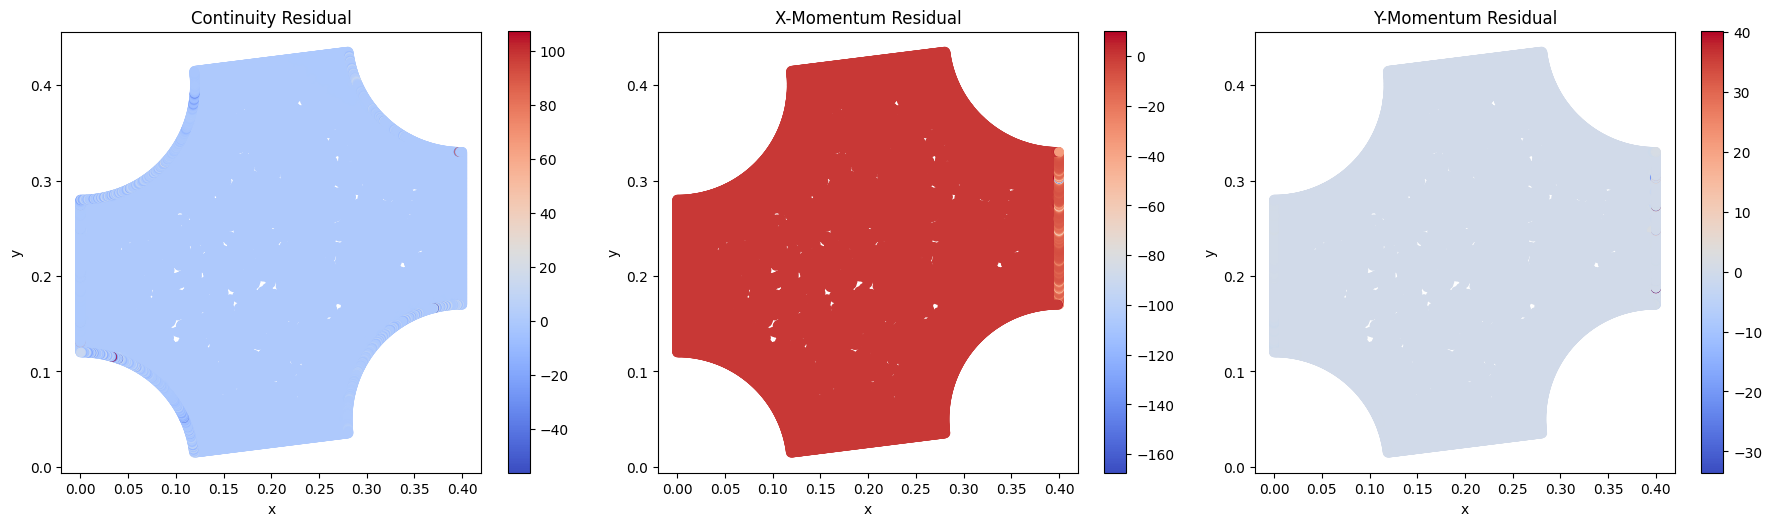

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

# Load the CSV file
mode = "label_free"
df = pd.read_csv(f'results/csv/test_{mode}_0.6_8_1.csv')  # Replace with your path

# Extract coordinates and fields
points = df[['x', 'y']].values
u = df['u'].values
v = df['v'].values
p = df['p'].values

# Interpolators
rbf_u = RBFInterpolator(points, u, kernel='thin_plate_spline')
rbf_v = RBFInterpolator(points, v, kernel='thin_plate_spline')
rbf_p = RBFInterpolator(points, p, kernel='thin_plate_spline')

# Gradient and Laplacian functions
def numerical_gradient(f_interp, pts, h=1e-4):
    grads = []
    for i in range(2):
        offset = np.zeros_like(pts)
        offset[:, i] = h
        grad_i = (f_interp(pts + offset) - f_interp(pts - offset)) / (2 * h)
        grads.append(grad_i)
    return grads

def numerical_laplacian(f_interp, pts, h=1e-4):
    lap = np.zeros(len(pts))
    for i in range(2):
        offset = np.zeros_like(pts)
        f_plus = f_interp(pts + offset)
        f_minus = f_interp(pts - offset)
        f_center = f_interp(pts)
        lap += (f_plus - 2 * f_center + f_minus) / h**2
    return lap

# Derivatives
du_dx, du_dy = numerical_gradient(rbf_u, points)
dv_dx, dv_dy = numerical_gradient(rbf_v, points)
dp_dx, dp_dy = numerical_gradient(rbf_p, points)
lap_u = numerical_laplacian(rbf_u, points)
lap_v = numerical_laplacian(rbf_v, points)

# Residuals
mu = 0.01
cont_res = du_dx + dv_dy
mom_x_res = u * du_dx + v * du_dy + dp_dx - mu * lap_u
mom_y_res = u * dv_dx + v * dv_dy + dp_dy - mu * lap_v

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sc1 = axs[0].scatter(points[:, 0], points[:, 1], c=cont_res, cmap='coolwarm')
axs[0].set_title('Continuity Residual')
plt.colorbar(sc1, ax=axs[0])

sc2 = axs[1].scatter(points[:, 0], points[:, 1], c=mom_x_res, cmap='coolwarm')
axs[1].set_title('X-Momentum Residual')
plt.colorbar(sc2, ax=axs[1])

sc3 = axs[2].scatter(points[:, 0], points[:, 1], c=mom_y_res, cmap='coolwarm')
axs[2].set_title('Y-Momentum Residual')
plt.colorbar(sc3, ax=axs[2])

for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [13]:
# Mean absolute residuals
avg_continuity = np.mean(np.abs(cont_res))
avg_momentum_x = np.mean(np.abs(mom_x_res))
avg_momentum_y = np.mean(np.abs(mom_y_res))

print("Average Continuity Residual: ", avg_continuity)
print("Average X-Momentum Residual: ", avg_momentum_x)
print("Average Y-Momentum Residual: ", avg_momentum_y)


Average Continuity Residual:  0.3851213079640335
Average X-Momentum Residual:  0.5411328511561003
Average Y-Momentum Residual:  0.03374334145199854
